<bound method NDFrame.head of      timestep     value
0           0  0.352810
1           1  0.179865
2           2  0.394417
3           3  0.743699
4           4  0.762930
..        ...       ...
995       995 -0.775221
996       996 -0.841876
997       997 -0.719744
998       998 -0.897111
999       999 -0.661547

[1000 rows x 2 columns]>


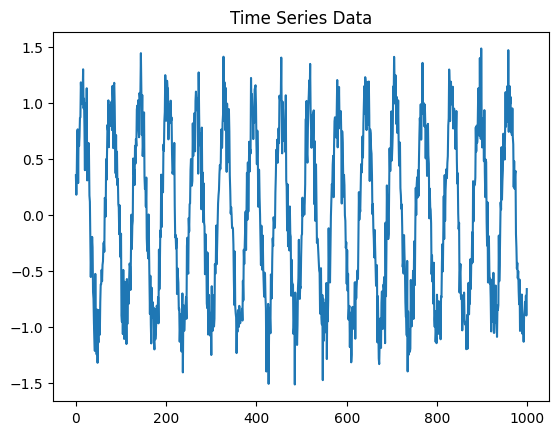

In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
# Generate some sample time series data
np.random.seed(0)
data_size = 1000
timesteps = np.arange(data_size)
values = np.sin(timesteps / 10) + np.random.normal(size=data_size) / 5

# Create a DataFrame
df = pd.DataFrame({
    'timestep': timesteps,
    'value': values,
})

print(df.head)
plt.plot(df['value'])
plt.title('Time Series Data')
plt.show()

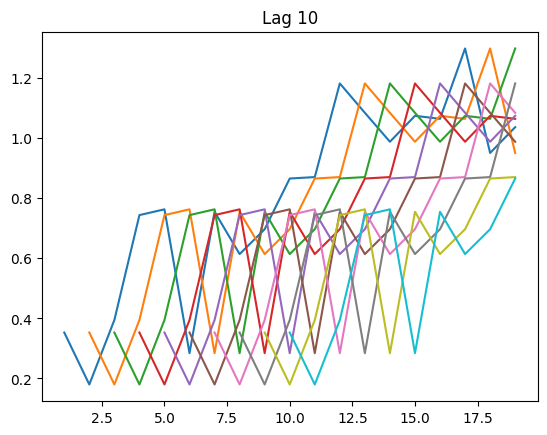

In [3]:
# Feature engineering: creating lag features
for lag in range(1, 11):
    df[f'lag_{lag}'] = df['value'].shift(lag)
    plt.plot(df[f'lag_{lag}'][:20])
    plt.title(f'Lag {lag}')
# Drop rows with NaN values created by lagging
df = df.dropna()
plt.show()

In [5]:
# Split data into features and target
X = df.drop(columns=['value'])
y = df['value']

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Train an XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [8]:
# Extract feature importances
feature_importances = model.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Print feature importances
print(importance_df)

     feature  importance
1      lag_1    0.735765
2      lag_2    0.119641
3      lag_3    0.028408
9      lag_9    0.022997
10    lag_10    0.018635
8      lag_8    0.017438
5      lag_5    0.015301
7      lag_7    0.014737
4      lag_4    0.013077
6      lag_6    0.010447
0   timestep    0.003554


In [9]:
# Select top features
selected_features = importance_df[importance_df['importance'] > 0.05]['feature'].tolist()

print("Selected features:", selected_features)

Selected features: ['lag_1', 'lag_2']


In [10]:
# Use selected features for further modeling
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train a new model with selected features
model_selected = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model_selected.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred = model_selected.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error with selected features: {mse}')

Mean Squared Error with selected features: 0.09282405074887037
